In [15]:
import math
import os
import time

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *
from torchdyn.core import NeuralODE

In [16]:
# set seed
seed = 1980
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = True

In [17]:
S40 = pd.read_csv("data/station_40.csv")
S49 = pd.read_csv("data/station_49.csv")
S63 = pd.read_csv("data/station_63.csv")
S90 = pd.read_csv("data/station_80.csv")

S40.rename(columns=lambda x: x + "_40" if x != "YEAR" else x, inplace=True)
S49.rename(columns=lambda x: x + "_49" if x != "YEAR" else x, inplace=True)
S63.rename(columns=lambda x: x + "_63" if x != "YEAR" else x, inplace=True)
S90.rename(columns=lambda x: x + "_90" if x != "YEAR" else x, inplace=True)

merged_df = pd.merge(S40, S49, on='YEAR', how='inner')
merged_df = pd.merge(merged_df, S63, on='YEAR', how='inner')
dataset = pd.merge(merged_df, S90, on='YEAR', how='inner')

dataset.set_index('YEAR', inplace=True)
target = ['YIELD_40', 'YIELD_49', 'YIELD_63', 'YIELD_90']
features = [x for x in dataset.columns if x not in target]

print(dataset.shape)
dataset.head()

(10000, 76)


,W_1_40,W_2_40,W_3_40,W_4_40,W_5_40,W_6_40,W_7_40,W_8_40,W_9_40,W_10_40,...,W_10_90,W_11_90,W_12_90,W_13_90,W_14_90,W_15_90,W_16_90,W_17_90,W_18_90,YIELD_90
YEAR,,,,,,,,,,,,,,,,,,,,,
0,21.389266,26.985066,23.813756,26.852214,25.096705,26.852109,25.730293,23.416002,21.038240,5.739711,...,1.027391,1.228816,1.324273,2.309497,2.917570,0.769869,0.907157,3.401885,1.037317,10.51
1,21.314074,22.516442,24.072042,29.159849,29.522392,26.567033,28.249854,24.606161,19.268685,1.891106,...,0.143191,0.925005,2.751680,1.196560,0.784046,1.505209,0.240757,1.617603,1.818209,6.61
2,20.875083,26.038845,24.516708,27.633776,26.951667,27.926496,26.534607,25.968638,23.554623,4.745318,...,0.942601,1.811827,2.923051,0.384716,2.876004,1.535451,1.509938,1.652338,0.279352,6.86
3,20.553688,20.992986,22.859027,28.654018,26.705206,24.458350,25.146936,21.531644,22.961974,8.479863,...,3.640015,0.956474,2.241502,1.893830,0.189264,2.049275,3.795690,0.404447,1.468172,5.32
4,21.523342,21.542900,23.034072,26.327315,30.362289,27.503657,27.839165,29.764479,18.290963,3.405621,...,1.191167,0.049557,0.330440,2.860207,0.399063,0.506497,1.700047,0.216837,2.166599,6.32


In [18]:
dataset['Q40'] = dataset['W_13_40'] + dataset['W_14_40'] + dataset['W_15_40']
dataset['Q49'] = dataset['W_13_49'] + dataset['W_14_49'] + dataset['W_15_49']
dataset['Q63'] = dataset['W_13_63'] + dataset['W_14_63'] + dataset['W_15_63']
dataset['Q90'] = dataset['W_13_90'] + dataset['W_14_90'] + dataset['W_15_90']

features = ['YIELD_40', 'YIELD_49', 'YIELD_63', 'YIELD_90']
aux_columns = ['Q40', 'Q49', 'Q63', 'Q90']
nb_weather_var = len([x for x in dataset.columns if not (x in features or x in aux_columns) ])

dataset = dataset[(dataset['Q40'] <= 3.3241) & (dataset['Q49'] <= 5.1292) & (dataset['Q63'] <= 6.4897) & (dataset['Q90'] <= 7.1301)]
print(dataset.shape)
dataset.head()

(282, 80)


,W_1_40,W_2_40,W_3_40,W_4_40,W_5_40,W_6_40,W_7_40,W_8_40,W_9_40,W_10_40,...,W_14_90,W_15_90,W_16_90,W_17_90,W_18_90,YIELD_90,Q40,Q49,Q63,Q90
YEAR,,,,,,,,,,,,,,,,,,,,,
23,21.564703,22.959052,21.748072,26.797087,26.532427,26.237242,28.259764,24.033738,21.405620,4.121663,...,1.128038,2.116548,0.730810,1.875634,1.261593,7.60,2.897652,3.838610,5.767649,4.631802
58,19.327546,21.985124,27.295237,26.714510,24.973771,28.525278,26.392510,25.773383,22.625087,7.053200,...,0.537331,0.783979,0.852335,2.728775,0.707441,3.62,2.192990,3.536142,3.674236,2.051027
78,23.644737,21.078385,25.192103,24.447685,27.087053,28.979942,25.257479,22.209522,21.852529,3.497465,...,0.918824,0.462014,0.898903,3.065462,1.307801,4.16,3.265079,3.306963,4.592905,2.074647
103,20.673938,21.250598,26.137802,25.259837,27.255545,29.100955,27.461326,24.529045,17.771249,3.084836,...,1.013362,3.424945,0.684240,0.698369,4.403090,7.93,2.406671,2.918724,5.256821,6.157511
114,20.155334,21.740500,22.811407,26.664845,30.675875,29.513566,26.389957,24.414434,23.965313,3.085839,...,2.606291,2.392429,0.996520,2.805743,1.255118,11.08,2.628130,2.708561,4.783734,6.325959


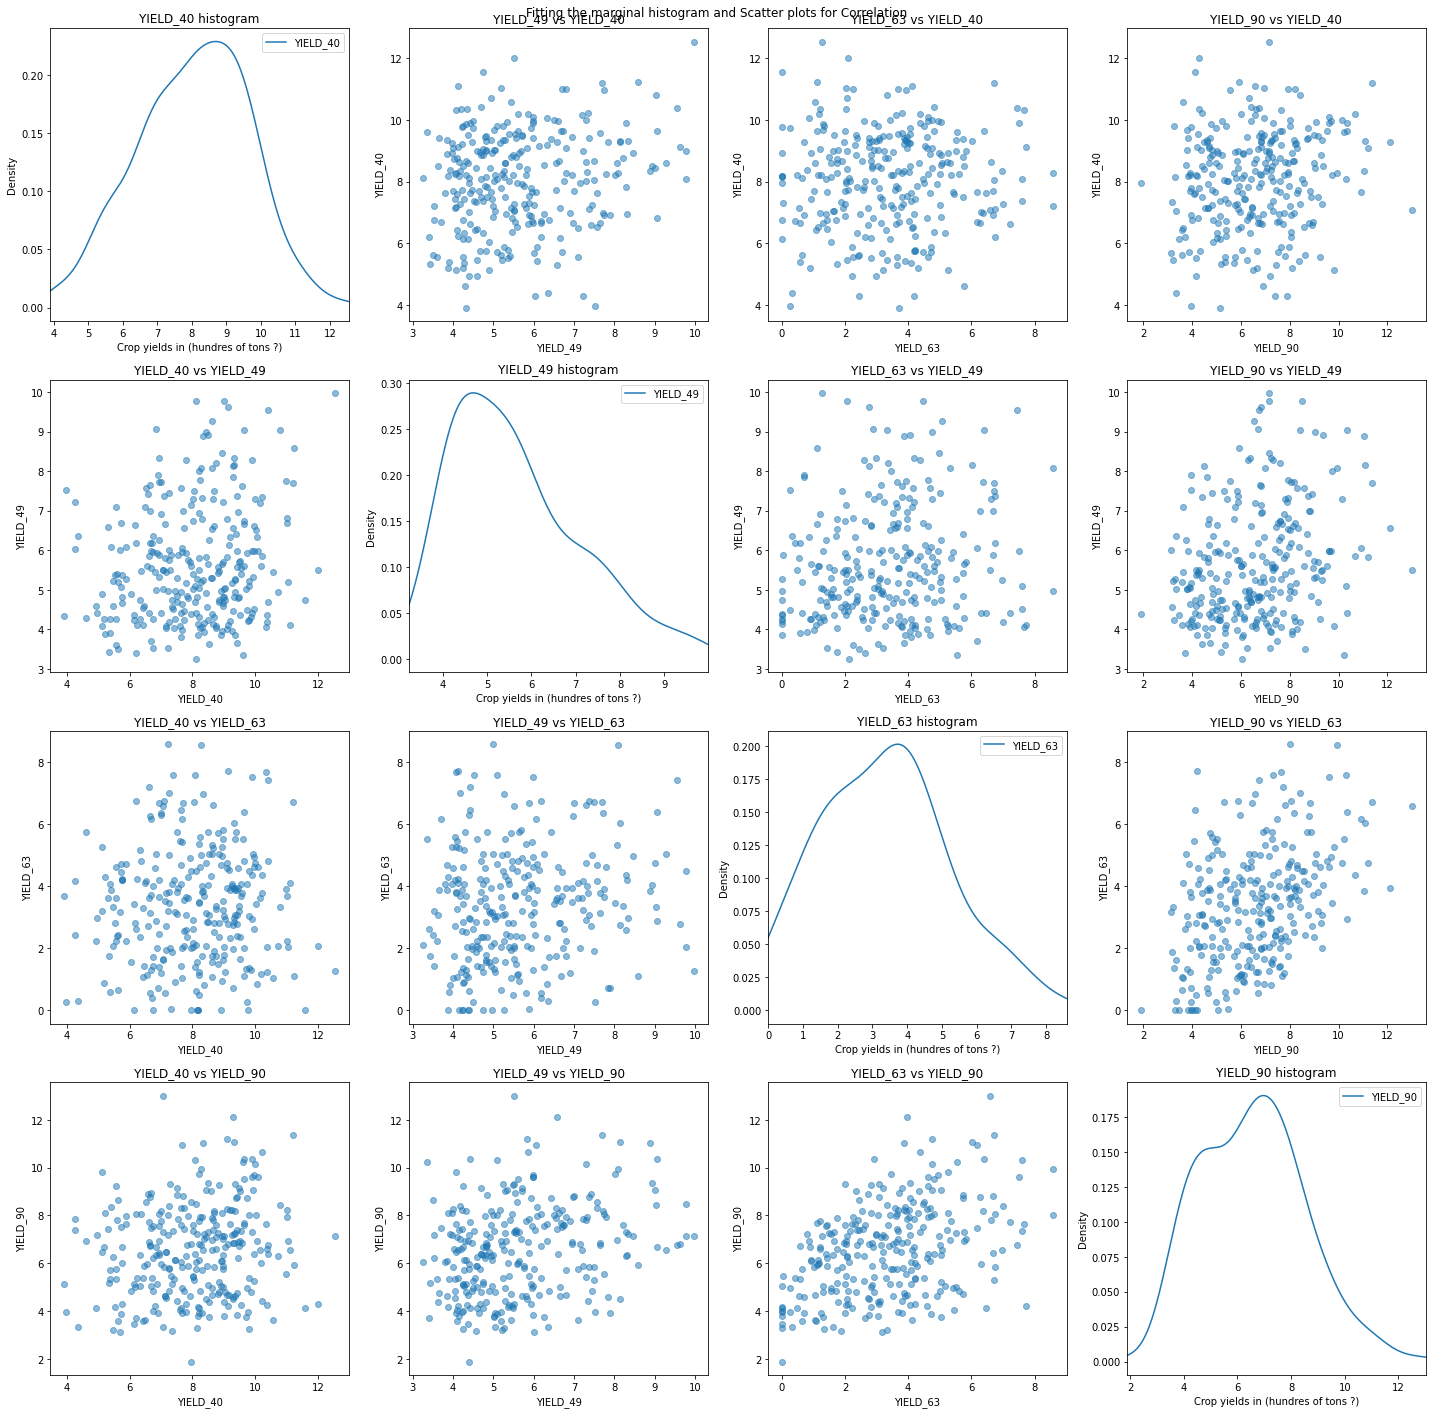

In [19]:
# Use only the YIELD data :
X= dataset[['YIELD_40', 'YIELD_49', 'YIELD_63', 'YIELD_90']]

# Plotting density plots
plt.figure(figsize=(20, 20))
for k in range(len(X.columns)):
    yield_ind = X.columns[k]
    plt.subplot(4, 4, 5*k + 1)

    X[yield_ind].plot.density()
    mu, std = X[yield_ind].mean(), X[yield_ind].std()
    xmin, xmax = np.min(X[yield_ind]), np.max(X[yield_ind])
    plt.xlim(xmin, xmax)

    plt.title(yield_ind + " histogram")
    plt.xlabel("Crop yields in (hundres of tons ?)")
    plt.ylabel("Density")
    plt.legend()

# Plotting scatter plots for correlation
for i in range(len(X.columns)):
    for j in range(len(X.columns)):
        if i != j:
            plt.subplot(4, 4, 1 + i + 4*j)

            x = X.iloc[:, i]
            y = X.iloc[:, j]

            plt.scatter(x, y, alpha=0.5)
            plt.title(f"{X.columns[i]} vs {X.columns[j]}")
            plt.xlabel(X.columns[i])
            plt.ylabel(X.columns[j])

plt.suptitle("Fitting the marginal histogram and Scatter plots for Correlation")
plt.tight_layout()
plt.show()


# Flow matching directly on the yields :

200: loss 0.958 time 2.88
400: loss 0.740 time 5.67
600: loss 0.380 time 8.50
800: loss 0.204 time 11.27
1000: loss 0.192 time 13.98
1200: loss 0.177 time 16.69
1400: loss 0.149 time 19.35
1600: loss 0.148 time 22.01
1800: loss 0.128 time 24.71
2000: loss 0.129 time 27.45


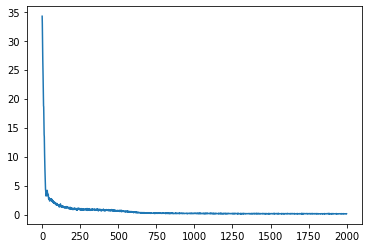

In [20]:
sigma = 0.1
dim = 4
batch_size = 256
model = MLP(dim=dim, time_varying=True, w=50)
optimizer = torch.optim.Adam(model.parameters())
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)

losses = []
start = time.time()
for k in range(2000):
    optimizer.zero_grad()

    x0 = torch.rand([batch_size,dim], dtype=torch.float32)
    x1 = torch.tensor(X.sample(n=batch_size, random_state=np.random.seed(seed)).values, dtype=torch.float32)

    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)

    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()

    if (k + 1) % 200 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")

plt.plot(losses)

In [84]:
nb_samples = 289

with torch.no_grad():
        node = NeuralODE(torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
        x0 = torch.rand([nb_samples,dim], dtype=torch.float32)
        traj = node.trajectory(
                x0,
                t_span=torch.linspace(0, 1, 100),
                )
        samples = pd.DataFrame(traj[-1].cpu().numpy())

print(samples.shape)

(289, 4)


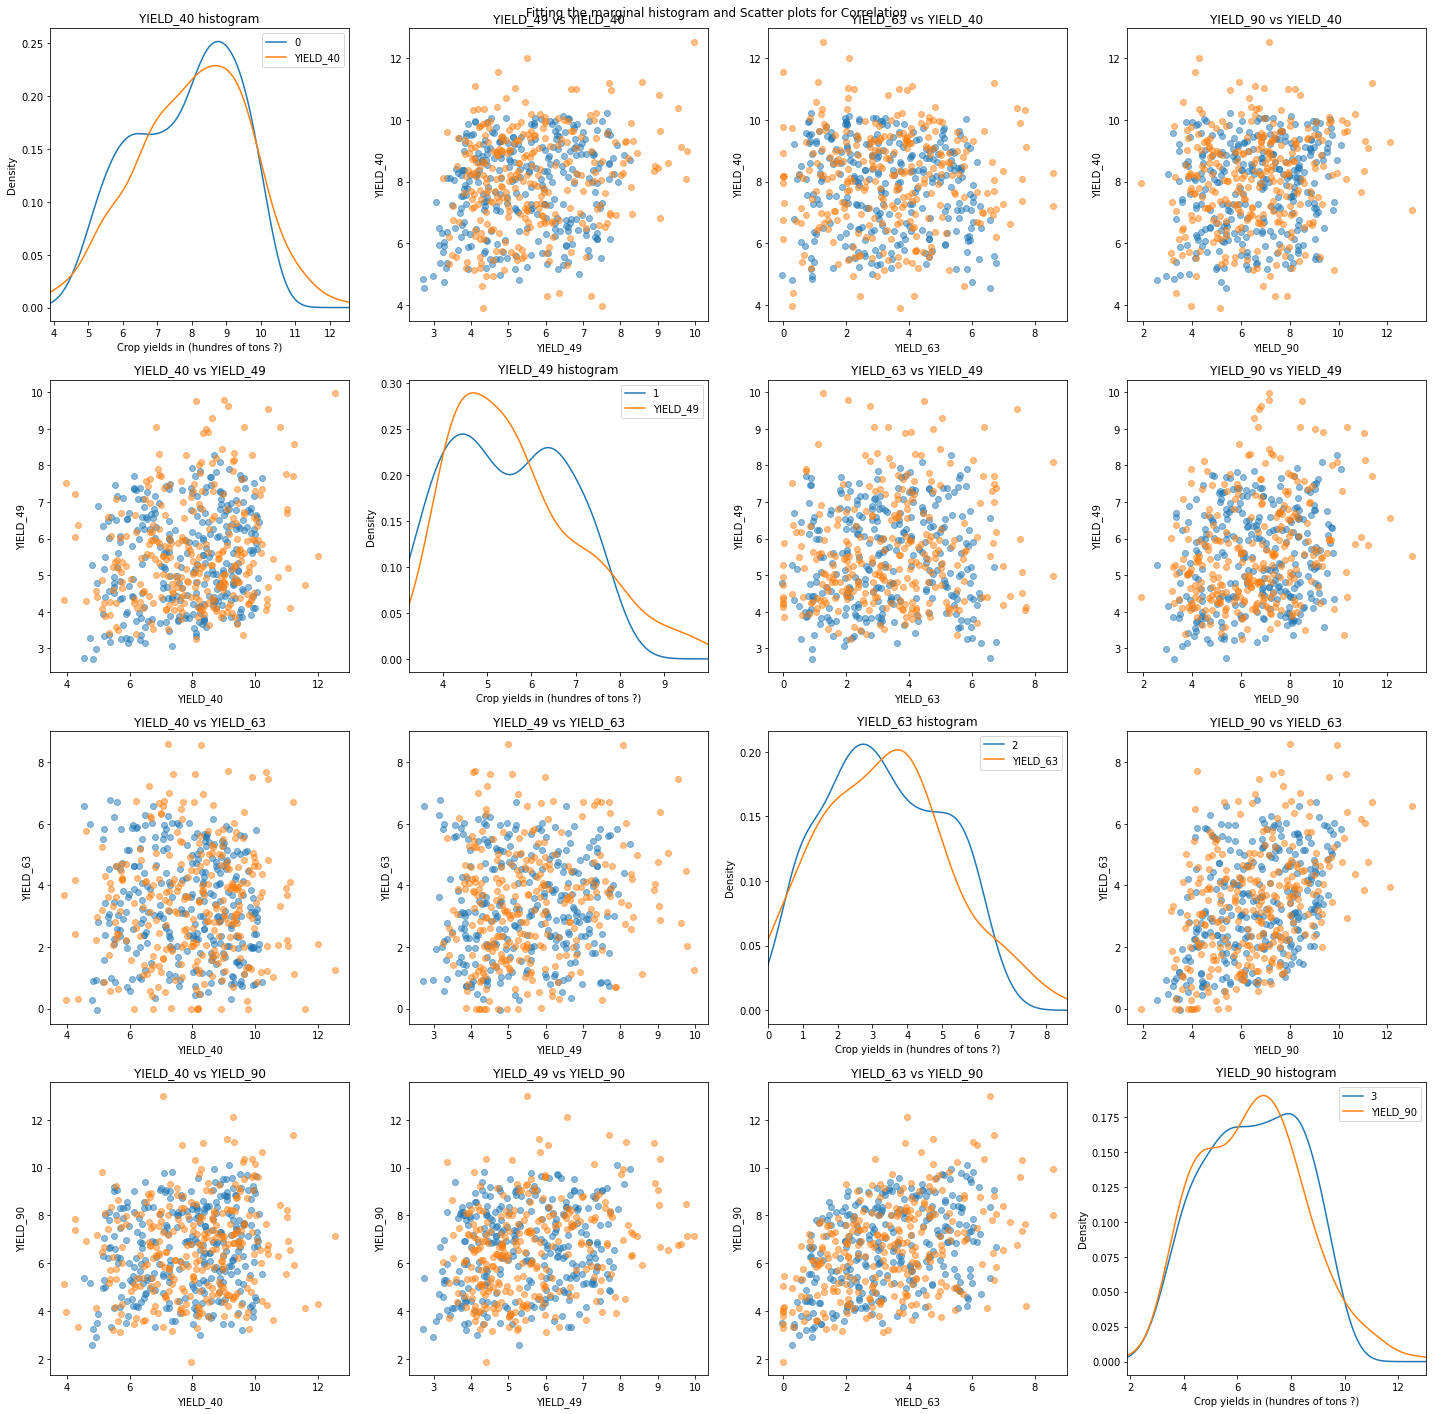

In [85]:
# Plotting density plots
plt.figure(figsize=(20, 20))
for k in range(samples.shape[1]):
    yield_ind = X.columns[k]
    plt.subplot(4, 4, 5*k + 1)

    samples[k].plot.density()
    X[yield_ind].plot.density()

    xmin, xmax = np.min(X[yield_ind]), np.max(X[yield_ind])
    plt.xlim(xmin, xmax)

    plt.title(yield_ind + " histogram")
    plt.xlabel("Crop yields in (hundres of tons ?)")
    plt.ylabel("Density")
    plt.legend()

# Plotting scatter plots for correlation
for i in range(samples.shape[1]):
    for j in range(samples.shape[1]):
        if i != j:
            plt.subplot(4, 4, 1 + i + 4*j)

            x = samples.iloc[:, i]
            y = samples.iloc[:, j]
            plt.scatter(x, y, alpha=0.5)

            x = X.iloc[:, i]
            y = X.iloc[:, j]
            plt.scatter(x, y, alpha=0.5)

            plt.title(f"{X.columns[i]} vs {X.columns[j]}")
            plt.xlabel(X.columns[i])
            plt.ylabel(X.columns[j])

plt.suptitle("Fitting the marginal histogram and Scatter plots for Correlation")
plt.tight_layout()
plt.show()


# Flow matching on the temperature then on the yields conditionaly on the temperature

In [21]:
weather = dataset[[x for x in dataset.columns if x not in ['YIELD_40', 'YIELD_49', 'YIELD_63', 'YIELD_90', 'Q40', 'Q49', 'Q63', 'Q90']]]

200: loss 2.643 time 3.23
400: loss 2.600 time 6.56
600: loss 2.664 time 9.82
800: loss 2.702 time 12.94
1000: loss 2.665 time 16.51
1200: loss 2.588 time 20.00
1400: loss 2.596 time 23.55
1600: loss 2.506 time 26.96
1800: loss 2.583 time 30.21
2000: loss 2.224 time 33.57
2200: loss 2.084 time 37.00
2400: loss 1.789 time 40.31
2600: loss 1.730 time 43.62
2800: loss 1.570 time 47.08
3000: loss 1.401 time 50.38
3200: loss 1.362 time 53.62
3400: loss 1.353 time 56.92
3600: loss 1.216 time 60.46
3800: loss 1.149 time 64.27
4000: loss 1.137 time 67.67
4200: loss 1.098 time 71.05
4400: loss 1.043 time 74.39
4600: loss 0.984 time 77.63
4800: loss 0.903 time 80.94
5000: loss 0.952 time 84.38


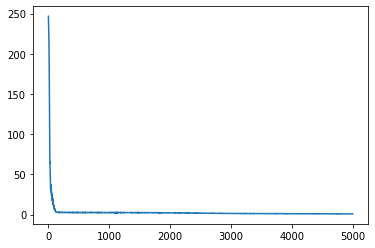

In [22]:
sigma = 0.2
weather_dim = weather.shape[1]
batch_size = 256
weather_model = MLP(dim=weather_dim, time_varying=True, w=64)
optimizer = torch.optim.Adam(weather_model.parameters())
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)

losses = []
start = time.time()
for k in range(5000):
    optimizer.zero_grad()

    w0 = torch.rand([batch_size,weather_dim], dtype=torch.float32)
    w1 = torch.tensor(weather.sample(n=batch_size, random_state=np.random.seed(seed)).values, dtype=torch.float32)

    t, wt, ut = FM.sample_location_and_conditional_flow(w0, w1)

    vt = weather_model(torch.cat([wt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()

    if (k + 1) % 200 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")

plt.plot(losses)

200: loss 2.031 time 3.35
400: loss 1.432 time 6.58
600: loss 1.153 time 9.91
800: loss 1.019 time 13.11
1000: loss 0.947 time 16.28
1200: loss 0.735 time 19.46
1400: loss 0.720 time 22.66
1600: loss 0.689 time 25.92
1800: loss 0.596 time 29.10
2000: loss 0.483 time 32.23
2200: loss 0.434 time 35.33
2400: loss 0.525 time 38.47
2600: loss 0.373 time 41.66
2800: loss 0.267 time 45.33
3000: loss 0.373 time 48.42


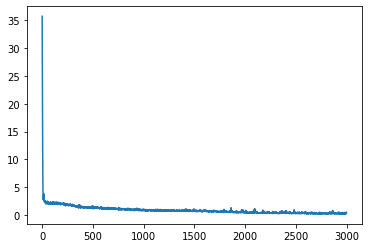

In [54]:

class MLP(torch.nn.Module):
    def __init__(self, dim, cond_dim=0, out_dim=None, w=64, time_varying=False):
        super().__init__()
        self.time_varying = time_varying
        if out_dim is None:
            out_dim = dim
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim + cond_dim + (1 if time_varying else 0), w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, out_dim),
        )

    def forward(self, x):
        return self.net(x)

sigma = 0.1
yields_dim = 4
batch_size = 256
cond_model = MLP(dim=yields_dim, cond_dim=weather_dim, time_varying=True, w=50)
optimizer = torch.optim.Adam(cond_model.parameters())
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)

losses = []
start = time.time()
for k in range(3000):
    optimizer.zero_grad()

    x0 = torch.rand([batch_size,yields_dim], dtype=torch.float32)

    data = dataset.sample(n=batch_size, random_state=np.random.seed(seed))
    x1 = torch.tensor(data[features].values, dtype=torch.float32)
    w1 = torch.tensor(data[[x for x in dataset.columns if not (x in features or x in aux_columns)]].values, dtype=torch.float32)

    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
    vt = cond_model(torch.cat([xt, w1, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()

    if (k + 1) % 200 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")

plt.plot(losses)

In [89]:
def sample_weather(weather_model, batch_size):
    node = NeuralODE(torch_wrapper(weather_model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
    w0 = torch.rand([batch_size,weather_dim], dtype=torch.float32)
    traj = node.trajectory(
            w0,
            t_span=torch.linspace(0, 1, 100),
            )
    return traj[-1]

def sample_yields(weather_model, cond_model, batch_size):
    weather_conds = sample_weather(weather_model, batch_size)
    node = NeuralODE(torch_wrapper(cond_model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
    rand = torch.rand((batch_size,yields_dim), dtype=torch.float32)
    print(weather_conds.shape, rand.shape)
    print(weather_conds.dtype, rand.dtype)
    x0 = torch.cat([rand, weather_conds], dim=-1) #WTF ? TODO: Solve this issue idk why it's not working as it should
    traj = node.trajectory(
            x0,
            t_span=torch.linspace(0, 1, 100),
            )
    return traj[-1]

sample_yields(weather_model, cond_model, 289)

torch.Size([289, 72]) torch.Size([289, 4])
torch.float32 torch.float32


RuntimeError: The size of tensor a (4) must match the size of tensor b (76) at non-singleton dimension 1